## Notebook to calculate the accuracy from an already saved model 

In [1]:
cd /scratch/zd2253/mainProject

/scratch/zd2253/mainProject


In [2]:
from models  import *
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn 
import torchvision.transforms as transforms
from torchvision import datasets as ds
from torch.utils.data import DataLoader
import torchvision as tv
import math
import numpy as np
from torchvision import transforms as ts
from torch.autograd import Variable
from torch import optim
from matplotlib import pyplot as plt
import torch.backends.cudnn as cudnn
from models  import *

In [ ]:
# function that takes in the test dataset and value of epsilon and uses the "model_adv" model we load before we run
# this function to attack and the model modelCurr we defined before as the current normal model--at the beginning of training

# returns a tuple of the normal accuracy, attacked model accuracy, the accuracy of the normal model with adversarial 
# examples as input

def FGSM_train(test_loader,epsilon, iterations = 1,min_val = -1,max_val = 1):
    correct = 0               
    adv_correct = 0
    normal_current_correct = 0
    adv_correct_test = 0
    misclassified = 0
    total = 0 
    adverserial_images = []
    y_preds = []
    y_preds_adv = []
    test_images = []
    test_label = []
    
      
      
    for i, (images,labels) in enumerate(test_loader):
        if torch.cuda.is_available():
            images = images.cuda()
            labels = labels.cuda()
            output_clean = modelCurr(Variable(images))
        images_adv = Variable(images.data,requires_grad = True)
    
        if torch.cuda.is_available():
            images_adv = images_adv.cuda()
        outputs = model_adv(images_adv)
        loss = criterion(outputs,Variable(labels))
        
        model_adv.zero_grad()
        if images_adv    .grad is not None:
            images.adv.grad.data.fill_(0)
        
        loss.backward()
        grad = torch.sign(images_adv.grad.data)   # Get the sign of the gradient
        
        images_adv = images_adv + (epsilon/iterations)*grad  
        images_adv = torch.where(images_adv > images + epsilon,images+epsilon,images_adv)
        images_adv = torch.where(images_adv < images-epsilon,images-epsilon,images_adv)
        images_adv = torch.clamp(images_adv,min_val,max_val)
        images_adv = Variable(images_adv.data,requires_grad = True)
    
    
        adv_output = model_adv(Variable(images_adv))
        adv_output_last_epoch = modelCurr(Variable(images_adv))
        output_current_epoch_normal= modelCurr(Variable(images))
        _,predicted = torch.max(output_clean.data,1)    # Ouput of the clean image
        _,adv_predicted = torch.max(adv_output.data,1) # Output of the image after adding adverserial noise
        _,adv_predicted_last_epoch = torch.max(adv_output_last_epoch.data,1) # Output of the image after adding     adverserial noise
        _,output_current_epoch_normal= torch.max(output_current_epoch_normal.data,1) # Output of the image     after adding adverserial noise
    
    
        adv_correct_test  += (adv_predicted_last_epoch == labels).sum().item()
        
        
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        adv_correct += (adv_predicted == labels).sum().item()
        normal_current_correct += (output_current_epoch_normal == labels).sum().item()
        misclassified += (predicted != adv_predicted).sum().item()
        
    
        
    
    temp = 100* normal_current_correct/total
    print('Acc without adv attack: on latest epoch                   {} %'.format(100*correct/total))
    print('Acc with adv attack-model where the adv attack happened   {} %'.format(100* adv_correct/total))
    print('Acc on latest epoch on the model with adv data as input : {} %'.format(100* adv_correct_test/total))
    #print('Acc on latest epoch :                                     {} %'.format(temp))
    
    return ((100*correct/total),(100* adv_correct/total),(100* adv_correct_test/total) )
 

In [ ]:
# function that takes the test dataset, the value of epsilon and the current model and the model 
# you want to attack as input--used to attack and input on whatever epoch we want
# returns accuracy of the current model, with adversarial examples as input, generated from the current epoch

modelAccuracy = np.array
modelAttackedAcc = np.array

def FGSM_attack(test_loader,epsilon, modelCurrent, model_adv):
 
    
    correct = 0               
    adv_correct = 0
    normal_current_correct = 0
    adv_correct_test = 0
    misclassified = 0
    total = 0 
    adverserial_images = []
    y_preds = []
    y_preds_adv = []
    test_images = []
    test_label = []
      
      
      
    for i, (images,labels) in enumerate(test_loader):
        if torch.cuda.is_available():
            images = images.cuda()
            labels = labels.cuda()
            output_clean = modelCurrent(Variable(images))
        images_adv = Variable(images.data,requires_grad = True)
    
        if torch.cuda.is_available():
            images_adv = images_adv.cuda()
        outputs = model_adv(images_adv)
        loss = criterion(outputs,Variable(labels))
        
        model_adv.zero_grad()
        if images_adv.grad is not None:
            images.adv.grad.data.fill_(0)
        
        loss.backward()
        grad = torch.sign(images_adv.grad.data)   # Get the sign of the gradient
        
        images_adv = images_adv + (epsilon/iterations)*grad  
        
        images_adv = torch.where(images_adv > images + epsilon,images+epsilon,images_adv)
        images_adv = torch.where(images_adv < images-epsilon,images-epsilon,images_adv)
        images_adv = torch.clamp(images_adv,min_val,max_val)
        images_adv = Variable(images_adv.data,requires_grad = True)
    
    
        adv_output = model_adv(Variable(images_adv))
        adv_output_last_epoch = modelCurrent(Variable(images_adv))
        output_current_epoch_normal= modelCurrent(Variable(images))
        _,predicted = torch.max(output_clean.data,1)    # Ouput of the clean image
        _,adv_predicted = torch.max(adv_output.data,1) # Output of the image after adding adverserial noise
        _,adv_predicted_last_epoch = torch.max(adv_output_last_epoch.data,1) # Output of the image after adding     adverserial noise
        _,output_current_epoch_normal= torch.max(output_current_epoch_normal.data,1) # Output of the image     after adding adverserial noise
    
    
        adv_correct_test  += (adv_predicted_last_epoch == labels).sum().item()
        
        
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        adv_correct += (adv_predicted == labels).sum().item()
        normal_current_correct += (output_current_epoch_normal == labels).sum().item()
        misclassified += (predicted != adv_predicted).sum().item()
        
    
        
    
    temp = 100* normal_current_correct/total
    print('Acc on latest epoch with adv examples generated from latest epoch : {} %'.format(100*     adv_correct_test/total))
    return ((100* adv_correct_test/total) )


In [4]:
model = VGG('VGG13')
model.cuda()

print()

In [5]:

transform = ts.Compose(
    [
        ts.ToTensor(),
        ts.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ]
)


testset = tv.datasets.CIFAR10(root='../input/',
                              train=False, download=True, transform=transform)

testloader = torch.utils.data.DataLoader(testset,
                                         batch_size=4, shuffle=True, num_workers=0)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


Files already downloaded and verified


In [6]:
cd savedModels/

/scratch/zd2253/mainProject/savedModels


### loading a random model

In [7]:
modelCurr = VGG('VGG13')
model_adv = VGG('VGG13')
modelMain = VGG('VGG13')
modelCurr.cuda()
model_adv.cuda()
modelMain.cuda()

print()

In [8]:
PATH = "/scratch/zd2253/mainProject/savedModelsFinal/model79.pt"
model.load_state_dict(torch.load(PATH))
model.eval()
model.cuda()


PATH = "/scratch/zd2253/mainProject/savedModelsFinal/model79.pt"
modelCurr.load_state_dict(torch.load(PATH))
modelCurr.eval()
modelCurr.cuda()

PATH = "/scratch/zd2253/mainProject/savedModels/model1.pt"
model_adv.load_state_dict(torch.load(PATH))
model_adv.eval()
model_adv.cuda()


PATH = "/scratch/zd2253/mainProject/savedModels/model195.pt"
modelMain.load_state_dict(torch.load(PATH))
modelMain.eval()
modelMain.cuda()
print()


#PATH = "/scratch/zd2253/mainProject/vggPretrained/modelVGG161.pt"
#model_adv.load_state_dict(torch.load(PATH))
#model_adv.eval()
#model_adv.cuda()
print()

In [9]:
criterion = nn.NLLLoss()

latest model: 1

Acc without adv attack: on latest epoch                   74.97 %
Acc with adv attack-model where the adv attack happened   51.43 %
Acc on latest epoch on the model with adv data as input : 51.43 %
Acc on latest epoch with adv examples generated from latest epoch : 51.43 %
Acc on latest epoch with adv examples generated from latest epoch : 73.1 %
latest model: 2

Acc without adv attack: on latest epoch                   78.87 %
Acc with adv attack-model where the adv attack happened   51.43 %
Acc on latest epoch on the model with adv data as input : 62.3 %
Acc on latest epoch with adv examples generated from latest epoch : 53.75 %
Acc on latest epoch with adv examples generated from latest epoch : 69.6 %
latest model: 3

Acc without adv attack: on latest epoch                   81.03 %
Acc with adv attack-model where the adv attack happened   51.43 %
Acc on latest epoch on the model with adv data as input : 64.22 %
Acc on latest epoch with adv examples generated from l

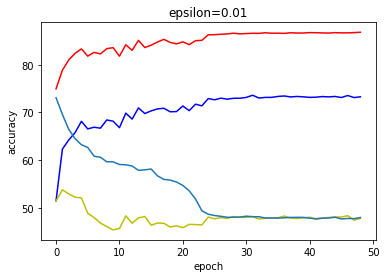

In [13]:
modelAccuracy200 = []
modelAttackedAcc200 = []
modelAdvAcc200 = []
modelAdvAcc200Current = []
modelAdvAcc200CurrentModel2 = []

epsilon = 0.01
           
t = 0          
#for z in epsilon:


for i in range(1,50,1):
    PATH = "/scratch/zd2253/mainProject/savedModels/model"+str(i)+".pt"
    modelCurr.load_state_dict(torch.load(PATH))
    modelCurr.eval()
    modelCurr.cuda()
    print("latest model: " +str(i)+'\n')

    test = FGSM_train(testloader, epsilon)
    modelAccuracy200.append(test[0])
    modelAttackedAcc200.append(test[1])
    modelAdvAcc200.append(test[2])
    modelAdvAcc200Current.append(FGSM_attack(testloader,epsilon, modelCurr, modelCurr))
    modelAdvAcc200CurrentModel2.append(FGSM_attack(testloader,epsilon, modelMain, modelCurr))
t = t + 1
#plt.plot(modelAccuracy2, modelAttackedAcc2,modelAdvAcc2 )

line1,= plt.plot(modelAccuracy200, 'r', label = "normal acc") # plotting t, a separately 
#line2, = plt.plot(modelAttackedAcc200, 'g', label = "adv ex") # plotting t, a separately 
line3, = plt.plot(modelAdvAcc200, 'b', label = "acc w adv ex (1st epoch) input") # plotting t, a separately 
line4, = plt.plot(modelAdvAcc200Current, 'y', label = "acc w adv ex (latest epoch) input") # plotting t, a separately 
line4, = plt.plot(modelAdvAcc200CurrentModel2, label = "acc w adv ex (latest epoch) input from Model 2") # plotting t, a separately 


plt.xlabel('epoch')
plt.ylabel('accuracy')
#plt.ylim([0, 100])
plt.title('epsilon=' + str(epsilon))
#leg = plt.legend(loc='lower center')
# function to show the plot
plt.show()